# 6. 어텐션 메커니즘 (Attention Mechanism)

이번 챕터에서는 신경망들의 성능을 높이기 위한 메커니즘이자, 이제는 AI 분야에서 대세 모듈로서 사용되고 있는 트랜스포머의 기반이 되는 어텐션 메커니즘에 대해서 학습합니다.

## 1) 어텐션 메커니즘 (Attention Mechanism)

앞서 배운 seq2seq 모델은 인코더에서 입력 시퀀스를 컨텍스트 벡터라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더는 이 컨텍스트 벡터를 통해서 출력 시퀀스를 만들어냈습니다.

하지만 이러한 RNN에 기반한 seq2seq 모델에는 크게 두 가지 문제가 있습니다.
첫째, 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생합니다.
둘째, RNN의 고질적인 문제인 기울기 소실(Vanishing Gradient) 문제가 존재합니다.

즉, 결국 이는 기계 번역 분야에서 입력 문장이 길면 번역 품질이 떨어지는 현상으로 나타났습니다. 이를 위한 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위한 등장한 기법인 어텐션(attention)을 소개합니다.

### 1. 어텐션(Attention)의 아이디어

어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점입니다. 단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)해서 보게 됩니다.

### 2. 어텐션 함수(Attention Function)

어텐션 메커니즘을 언급하기 전에 컴퓨터공학의 많은 분야에서 사용되는 Key-Value로 구성되는 자료형에 대해서 잠깐 언급하겠습니다. 가령, 이 책의 주 언어로 사용되는 파이썬에도 Key-Value로 구성되는 자료형인 딕셔너리(Dict) 자료형이 존재합니다. 파이썬의 딕셔너리 자료형은 키(Key)와 값(Value)이라는 두 개의 쌍으로 구성되는데, 키를 통해서 맵핑된 값을 찾아낼 수 있다는 특징을 갖고있습니다.

In [78]:
# 파이썬의 딕셔너리 자료형을 선언
# 키(Key) : 값(value)의 형식으로 키와 값의 쌍(Pair)을 선언한다.
dict = {"2017" : "Transformer", "2018" : "BERT"}

위의 자료형에서 2017은 키에 해당되며, Transformer는 2017의 키와 맵핑되는 값에 해당됩니다. 그와 마찬가지로 2018은 키에 해당되며, BERT는 2018이라는 키와 맵핑되는 값에 해당됩니다.

In [79]:
print(dict["2017"]) #2017이라는 키에 해당되는 값을 출력

Transformer


In [80]:
print(dict["2018"])  #2018이라는 키에 해당되는 값을 출력

BERT


Key-Value 자료형에 대한 이해를 가지고, 어텐션 함수에 대해서 설명해보겠습니다.

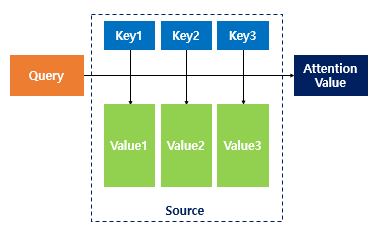

어텐션을 함수로 표현하면 주로 다음과 같이 표현됩니다.  
  
Attention(Q, K, V) = Attention Value

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해줍니다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 리턴합니다. 여기서는 이를 어텐션 값(Attention Value)이라고 하겠습니다.

지금부터 배우게 되는 seq2seq + 어텐션 모델에서 Q, K, V에 해당되는 각각의 Query, Keys, Values는 각각 다음과 같습니다.

Q = Query : t 시점의 디코더 셀에서의 은닉 상태
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
V = Values : 모든 시점의 인코더 셀의 은닉 상태들
이제 매우 간소화 된 어텐션 예제를 통해 어텐션을 이해해보도록 하겠습니다.

### 3. 닷-프로덕트 어텐션(Dot-Product Attention)

어텐션은 다양한 종류가 있는데 그 중에서도 가장 수식적으로 이해하기 쉽게 수식을 적용한 닷-프로덕트 어텐션(Dot-Product Attention)을 통해 어텐션을 이해해보도록 하겠습니다. seq2seq에서 사용되는 어텐션 중에서 닷-프로덕트 어텐션과 다른 어텐션의 차이는 주로 중간 수식의 차이로 메커니즘 자체는 거의 유사합니다.

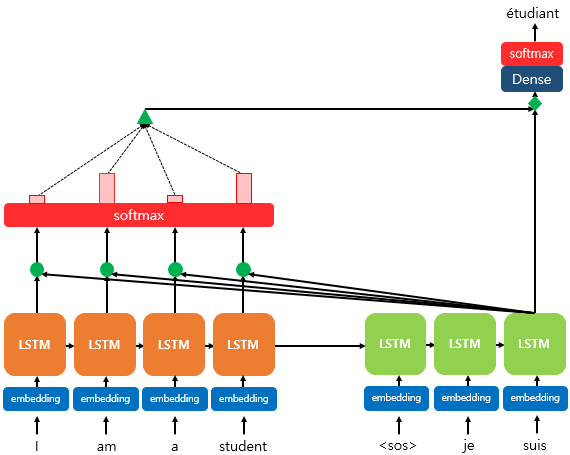

위 그림은 디코더의 세번째 LSTM 셀에서 출력 단어를 예측할 때, 어텐션 메커니즘을 사용하는 모습을 보여줍니다. 디코더의 첫번째, 두번째 LSTM 셀은 이미 어텐션 메커니즘을 통해 je와 suis를 예측하는 과정을 거쳤다고 가정합니다. 어텐션 메커니즘에 대해 상세히 설명하기 전에 위의 그림을 통해 전체적인 감만 우선 잡고 들어가보겠습니다. 디코더의 세번째 LSTM 셀은 출력 단어를 예측하기 위해서 인코더의 모든 입력 단어들의 정보를 다시 한번 참고하고자 합니다. 중간 과정에 대한 설명은 현재는 생략하고 여기서 주목할 것은 인코더의 소프트맥스 함수입니다.

소프트맥스 함수를 통해 나온 결과값은 I, am, a, student 단어 각각이 출력 단어를 예측할 때 얼마나 도움이 되는지의 정도를 수치화한 값입니다. 위의 그림에서는 빨간 직사각형의 크기로 소프트맥스 함수의 결과값의 크기를 표현했습니다. 직사각형의 크기가 클 수록 도움이 되는 정도의 크기가 큽니다. 각 입력 단어가 디코더의 예측에 도움이 되는 정도가 수치화하여 측정되면 이를 하나의 정보로 담아서 디코더로 전송됩니다. 위의 그림에서는 초록색 삼각형이 이에 해당됩니다. 결과적으로, 디코더는 출력 단어를 더 정확하게 예측할 확률이 높아집니다. 이제 어텐션 메커니즘에 대한 전체적인 감을 잡았으면 어텐션 메커니즘에 대해 상세히 알아보겠습니다.

### 1) 어텐션 스코어(Attention Score)를 구한다.

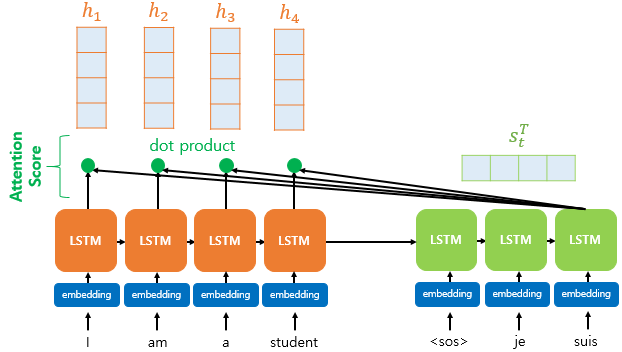

인코더의 시점(time step)을 각각 1, 2, ... N이라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 h1, h2, ... hN라고 합시다. 디코더의 현재 시점(time step) t에서의 디코더의 은닉 상태(hidden state)를 st라고 합시다. 또한 여기서는 인코더의 은닉 상태와 디코더의 은닉 상태의 차원이 같다고 가정합니다. 위의 그림의 경우에는 인코더의 은닉 상태와 디코더의 은닉 상태가 동일하게 차원이 4입니다.

어텐션 메커니즘의 첫 걸음인 어텐션 스코어(Attention score)에 대해서 배우기전에, 이전 챕터에서 배웠던 디코더의 현재 시점 t에서 필요한 입력값을 다시 상기해보겠습니다. 시점 t에서 출력 단어를 예측하기 위해서 디코더의 셀은 두 개의 입력값을 필요로 하는데, 바로 이전 시점인 t-1의 은닉 상태와 이전 시점 t-1에 나온 출력 단어입니다.

그런데 어텐션 메커니즘에서는 출력 단어 예측에 또 다른 값을 필요로 하는데 바로 어텐션 값(Attention Value)이라는 새로운 값입니다. t번째 단어를 예측하기 위한 어텐션 값을 at이라고 정의하겠습니다.

어텐션 값이라는 새로운 개념이 등장한 만큼, 어텐션 값이 현재 시점 t에서의 출력 예측에 구체적으로 어떻게 반영되는지는 뒤에서 설명하겠습니다. 지금부터 배우는 모든 과정은 at를 구하기 위한 여정입니다. 그리고 그 여정의 첫 걸음은 바로 어텐션 스코어(Attention Score)를 구하는 일입니다. 어텐션 스코어란 현재 디코더의 시점 t에서 단어를 예측하기 위해, 인코더의 모든 은닉 상태 각각이 디코더의 현 시점의 은닉 상태 st와 얼마나 유사한지를 판단하는 스코어값입니다.

닷-프로덕트 어텐션에서는 이 스코어 값을 구하기 위해 st를 전치(transpose)하고 각 은닉 상태와 내적(dot product)을 수행합니다. 즉, 모든 어텐션 스코어 값은 스칼라입니다. 예를 들어 st과 인코더의 i번째 은닉 상태의 어텐션 스코어의 계산 방법은 아래와 같습니다.

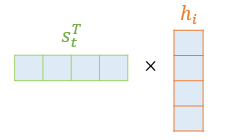

어텐션 스코어 함수를 정의해보면 다음과 같습니다.

$score(s_{t},\ h_{i}) = s_{t}^Th_{i}$

$s_t$와 인코더의 모든 은닉 상태의 어텐션 스코어의 모음값을 $e^t$라고 정의하겠습니다. $e^t$의 수식은 다음과 같습니다.  

$e^{t}=[s_{t}^Th_{1},...,s_{t}^Th_{N}]$

#### 2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.

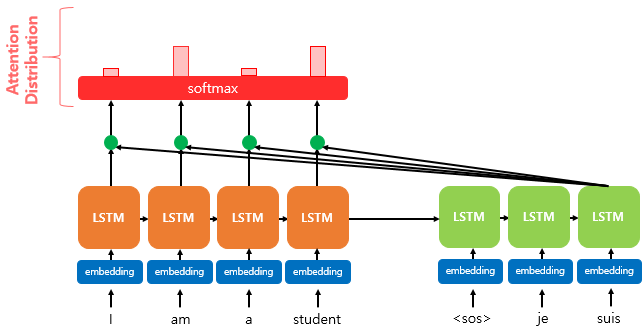

et에 소프트맥스 함수를 적용하여, 모든 값을 합하면 1이 되는 확률 분포를 얻어냅니다. 이를 어텐션 분포(Attention Distribution)라고 하며, 각각의 값은 어텐션 가중치(Attention Weight)라고 합니다. 예를 들어 소프트맥스 함수를 적용하여 얻은 출력값인 I, am, a, student의 어텐션 가중치를 각각 0.1, 0.4, 0.1, 0.4라고 합시다. 이들의 합은 1입니다. 위의 그림은 각 인코더의 은닉 상태에서의 어텐션 가중치의 크기를 직사각형의 크기를 통해 시각화하였습니다. 즉, 어텐션 가중치가 클수록 직사각형이 큽니다.

디코더의 시점 t에서의 어텐션 가중치의 모음값인 어텐션 분포를 αt이라고 할 때, αt을 식으로 정의하면 다음과 같습니다.

$α^{t} = softmax(e^{t})$

#### 3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.

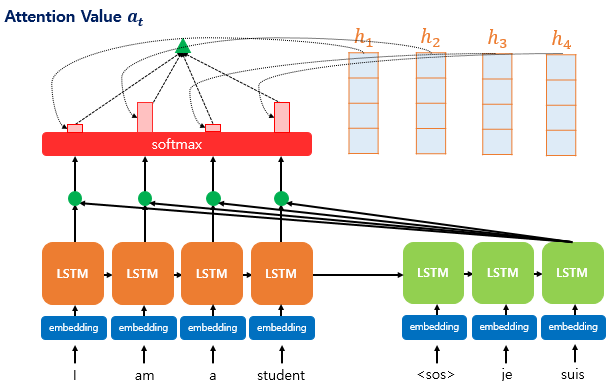

이제 지금까지 준비해온 정보들을 하나로 합치는 단계입니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 요약하면 가중합(Weighted Sum)을 한다고 말할 수도 있겠습니다. 아래는 어텐션의 최종 결과. 즉, 어텐션 함수의 출력값인 어텐션 값(Attention Value) at에 대한 식을 보여줍니다.

$a_{t}=\sum_{i=1}^{N} α_{i}^{t}h_{i}$

이러한 어텐션 값 at은 종종 인코더의 문맥을 포함하고 있다고하여, 컨텍스트 벡터(context vector)라고도 불립니다. 앞서 배운 가장 기본적인 seq2seq에서는 인코더의 마지막 은닉 상태를 컨텍스트 벡터라고 부르는 것과 대조됩니다.

#### 4) 어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.(Concatenate)

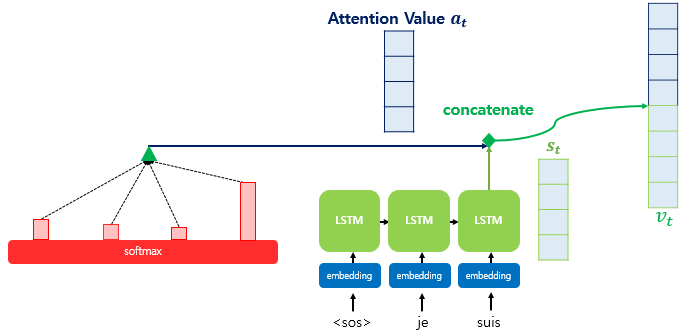

이제 어텐션 함수의 최종값인 어텐션 값 at을 구했습니다. 앞서 어텐션 메커니즘이 들어간 t시점의 은닉 상태를 구하는 방법의 식으로 다음과 같은 식을 소개한 바 있습니다. 사실 어텐션 값이 구해지면 어텐션 메커니즘은 at를 st와 결합(concatenate)하여 하나의 벡터로 만드는 작업을 수행합니다. 이를 vt라고 정의해보겠습니다. 그리고 이 vt를 y^ 예측 연산의 입력으로 사용하므로서 인코더로부터 얻은 정보를 활용하여 y^를 좀 더 잘 예측할 수 있게 됩니다. 이것이 어텐션 메커니즘의 핵심입니다.

#### 5) 출력층 연산의 입력이 되는 s~t를 계산합니다.

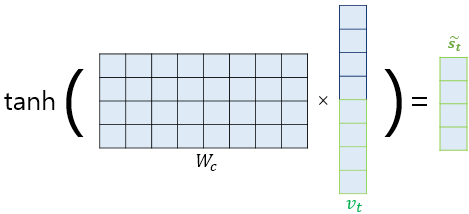

논문에서는 vt를 바로 출력층으로 보내기 전에 신경망 연산을 한 번 더 추가하였습니다. 가중치 행렬과 곱한 후에 하이퍼볼릭탄젠트 함수를 지나도록 하여 출력층 연산을 위한 새로운 벡터인 $\tilde{{s}}_{t}$를 얻습니다. 어텐션 메커니즘을 사용하지 않는 seq2seq에서는 출력층의 입력이 t시점의 은닉 상태인 st였던 반면, 어텐션 메커니즘에서는 출력층의 입력이 s~t가 되는 셈입니다.

이를 식으로 표현하면 다음과 같습니다. 식에서 Wc는 학습 가능한 가중치 행렬, bc는 편향입니다. 그림에서 편향은 생략했습니다.

$\tilde{s}_{t} = \tanh(\mathbf{W_{c}}[{α}_t;{s}_t] + b_{c})$

#### 6) s~t를 출력층의 입력으로 사용합니다.

s~t를 출력층의 입력으로 사용하여 예측 벡터를 얻습니다.

$\widehat{y}_t = \text{Softmax}\left( W_y\tilde{s}_t + b_y \right)$

## 2) 텍스트 요약(Text Summarization with Attention mechanism)

텍스트 요약은 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환하는 것을 말합니다. 읽는 사람이 시간을 단축해서 내용을 빠르게 이해할 수 있다는 점에서 글을 많이 쓰는 사람들에게는 꼭 필요한 능력 중 하나인 것 같습니다. 그런데 만약 기계가 이를 자동으로 해줄 수만 있다면 얼마나 좋을까요? 이번 챕터에서는 그 중 한 가지 방법인 seq2seq를 구현해보겠습니다. 그리고 어텐션 메커니즘(attention mechanism)을 적용해봅시다.

### 1. 텍스트 요약(Text Summarization)

텍스트 요약은 크게 추출적 요약(extractive summarization)과 추상적 요약(abstractive summarization)으로 나뉩니다.

#### 1) 추출적 요약(extractive summarization)

추출적 요약은 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법입니다. 그렇기 때문에 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들입니다. 추출적 요약의 대표적인 알고리즘으로 머신 러닝 알고리즘인 텍스트랭크(TextRank)가 있는데, 아래의 링크에서 텍스트랭크로 구현된 세 줄 요약기를 시험해볼 수 있습니다.

링크 : https://summariz3.herokuapp.com/

위 링크로 이동하여 인터넷 뉴스나 가지고 있는 글을을 복사 + 붙여넣기하여 결과를 살펴보세요. 세 개의 문장은 전부 원문에 존재하던 문장들입니다. 이 방법의 단점이라면, 이미 존재하는 문장이나 단어구로만 구성하므로 모델의 언어 표현 능력이 제한된다는 점입니다.

그렇다면 마치 사람처럼 원문에 없던 단어나 문장을 사용하면서 핵심만 간추려서 표현하는 요약 방법은 없을까요?

#### 2) 추상적 요약(abstractive summarization)

추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법입니다. 마치 사람이 요약하는 것 같은 방식인데, 당연히 추출적 요약보다는 난이도가 높습니다. 이 방법은 주로 인공 신경망을 사용하며 대표적인 모델로 seq2seq가 있습니다. 이 방법의 단점이라면 seq2seq와 같은 인공 신경망들은 기본적으로 지도 학습이라는 점입니다. 다시 말해 추상적 요약을 인공 신경망으로 훈련하기 위해서는 '원문' 뿐만 아니라 '실제 요약문'이라는 레이블 데이터가 있어야 합니다. 그렇기 때문에 데이터를 구성하는 것 자체가 하나의 부담입니다. 이번 챕터에서는 이미 공개된 데이터를 사용해서 추상적 요약을 실습해보겠습니다.

### 2. 아마존 리뷰 데이터에 대한 이해

이번 챕터에서 사용할 데이터는 아마존 리뷰 데이터입니다. 아래의 링크에서 데이터를 다운로드합니다.
링크 : https://www.kaggle.com/snap/amazon-fine-food-reviews

우선 실습에 필요한 도구들을 임포트합니다.

In [81]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 1) 데이터 로드하기

Reviews.csv 파일을 불러와 데이터프레임에 저장하겠습니다. 이 데이터는 실제로는 약 56만개의 샘플을 가지고 있습니다. 하지만 여기서는 간단히 10만개의 샘플만 사용하겠습니다. 이는 pd.read_csv의 nrows의 인자로 10만이라는 숫자를 적어주면 됩니다.

In [82]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_csv("Reviews.csv", nrows = 100000)
print('전체 리뷰 개수 :',(len(data)))

전체 리뷰 개수 : 100000


전체 리뷰 개수가 10만개인 것을 확인했습니다. 5개의 샘플만 출력해봅시다.

In [83]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


5개의 샘플을 출력해보면 'Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'이라는 10개의 열이 존재함을 알 수 있습니다. 그런데 사실 이 중 필요한 열은 'Text'열과 'Summary'열 뿐입니다.

Text열과 Summary열만을 분리하고, 다른 열들은 데이터에서 제외시켜서 재저장합니다. 그리고 5개의 샘플을 출력합니다.

In [84]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


Text열과 Summary열만 저장된 것을 확인할 수 있습니다. Text열이 원문이고, Summary열이 Text열에 대한 요약입니다. 다시 말해 모델은 Text(원문)으로부터 Summary(요약)을 예측하도록 훈련됩니다. 랜덤으로 샘플 몇 가지를 더 출력해봅시다.

In [85]:
# 랜덤으로 10개의 샘플 출력
data.sample(10)

,Text,Summary
52323,I've found with so many k-cups that they just ...,Nice black coffee k-cup
82708,If you have a Nespresso<br />machine and want ...,Good option!
68204,I bought several brands of microwave pork rind...,best microwave pork rinds
18526,I have just found out today that the gelatin i...,Pork gelatin!!!!!
88248,This is my second time purchasing this product...,GREAT BUY
66930,"Heed my advice! When you go to eat this, meas...",Dangerously delicious
32378,"I'm disturbed that these treats, as many revie...",BEWARE: MADE IN CHINA
84805,I was looking for a good tea to replace some e...,Good tea
41191,Everybody who knows me knows I like licorice. ...,Yum!
18186,I'm a peanut butter addict but since going on ...,Great for those on WW!


여기서는 data.sample(10)를 한 번만 실행했지만 지속적으로 몇 차례 더 실행하면서 샘플의 구조를 확인해보세요. 원문은 꽤 긴 반면에, Summary에는 3~4개의 단어만으로 구성된 경우도 많아보입니다.

#### 2) 데이터 정제하기

데이터에 중복 샘플이 있는지 확인해보겠습니다.

In [86]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


전체 데이터는 10만개의 샘플이 존재하지만, 실제로는 꽤 많은 원문이 중복되어 중복을 배제한 유일한 원문의 개수는 88,426개입니다. 중복 샘플이 무려 약 1,200개나 있다는 의미지요. Summary는 중복이 더 많지만, 원문은 다르더라도 짧은 문장인 요약은 내용이 겹칠 수 있음을 가정하고 일단 두겠습니다. Summary의 길이 분포는 뒤에서 확인하겠습니다.

In [87]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 88426


중복을 제거하여 88,426개의 샘플만 존재합니다. 이제 Null 샘플이 존재하는지 확인해봅시다.

In [88]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


Summary에서 1개의 Null 샘플이 남아있습니다. 이를 제거해줍니다.

In [89]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88425


이제 남은 샘플 수는 88,425개입니다. 지금까지는 불필요한 샘플의 수를 줄이기 위한 정제 과정이었습니다. 이제 샘플 내부를 전처리해야 합니다. 단어 정규화와 불용어 제거를 위해 각각의 참고 자료가 필요합니다. 동일한 의미를 가졌지만 스펠링이 다른 단어들을 정규화하기 위한 사전을 만듭니다. 이 사전은 아래의 링크를 참고하여 만들어진 사전입니다.

링크 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [90]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

NLTK의 불용어를 저장하고 개수를 확인해봅시다.

In [91]:
# NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'didn', 'a', 'to', 'm', 'if', 'not', 're', 'over', "didn't", 'who', 'out', 'is', 'but', 'we', 'hers', 'below', 'shan', 'during', "mustn't", 'up', 'why', 'here', 'against', 'nor', 'do', 'doesn', "hadn't", 'now', "mightn't", 'has', "she's", 't', 'myself', 'o', 've', 'its', 'some', 'other', 'weren', "that'll", 'through', 'ourselves', 'such', 'in', 'mustn', 'very', 'wouldn', 'yourselves', 'for', "isn't", 'until', 'same', 'so', 'can', 'been', 'needn', 'aren', 'herself', 'haven', "aren't", 'did', 'off', 'his', 'mightn', "doesn't", 'into', 'few', "you'll", 'their', 'hadn', 'doing', "wasn't", "you're", 'have', 'with', 'after', 'will', "don't", "haven't", "hasn't", 'under', 'what', "couldn't", 'those', 'all', "weren't", 'don', 'this', "you've", 'of', "needn't", 'had', 'be', 'he', 'won', 'as', 'hasn', 'own', 'himself', 'any', 'itself', 'further', 'ain', 's', 'once', 'were', 'between', 'just', 'being', 'couldn', 'and', 'she', 'am', 'the', 'her', 'me', 'when', "you'd", "shan't", 'you

전처리 함수를 설계합니다.

In [92]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

함수 내부의 각 줄에 주석을 달았으므로 자세한 설명은 생략하겠습니다. 여기서는 Text 열에서는 불용어를 제거하고, Summary 열에서는 불용어를 제거하지 않기로 결정했습니다. Summary를 입력으로 할 때는 두번째 인자를 0으로 줘서 불용어를 제거하지 않는 버전을 실행하겠습니다. 임의의 Text 문장과 Summary 문장을 만들어 전처리 함수를 통한 전처리 후의 결과를 확인해보겠습니다.

In [93]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


우선 Text 열에 대해서 전처리를 수행하겠습니다. 전처리 후에는 5개의 전처리 된 샘플을 출력합니다.

In [94]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

이제 Summary 열에 대해서 전처리를 수행하겠습니다. 전처리 후에는 5개의 전처리 된 샘플을 출력합니다.

In [95]:
# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

C:\Users\jg91\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\jg91\anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

전처리 후의 결과를 다시 데이터프레임에 저장합니다.

In [96]:
data['Text'] = clean_text
data['Summary'] = clean_summary

혹시 전처리 과정에서 빈 값이 생겼다면 Null 값으로 변경한 후에 Null 값을 가진 샘플이 생겼는지 확인합니다.

In [97]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


Summary 열에서 70개의 샘플이 Null 값을 가집니다. 이 샘플들을 제거해주고, 전체 샘플수를 확인합니다.

In [98]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88355


이제 Text 열과 Summary 열에 대해서 길이 분포를 확인해보겠습니다.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


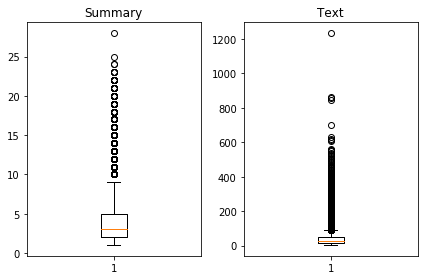

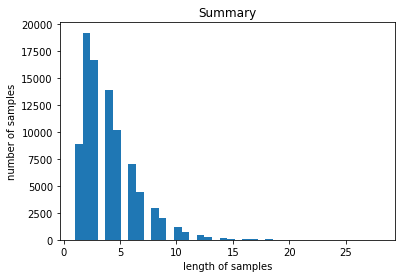

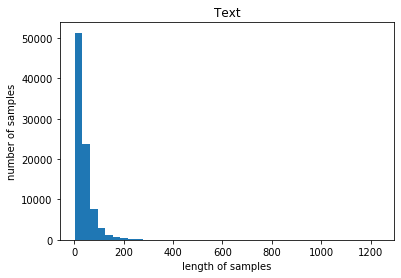

In [99]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

원문 텍스트는 대체적으로 100이하의 길이를 가집니다. 또한, 평균 길이는 38입니다. 요약의 경우에는 대체적으로 15이하의 길이를 가지며 평균 길이는 4입니다. 여기서 패딩의 길이를 정하겠습니다. 평균 길이보다는 크게 잡아 각각 50과 8로 결정합니다.

In [135]:
text_max_len = 30
summary_max_len = 4

50과 8이라는 이 두 길이가 얼마나 많은 샘플들의 길이보다 큰지 확인해보겠습니다.

In [136]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

우선 Text열에 대해서 확인해봅시다.

In [137]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 30 이하인 샘플의 비율: 0.7166884438907289


Text 열은 길이가 50 이하인 비율이 77%입니다. 약 23%의 샘플이 길이 50보다 큽니다. Summary 열에 대해서 확인해봅시다.

In [138]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 4 이하인 샘플의 비율: 0.3750037983530341


Summary 열은 길이가 8 이하인 경우가 94%입니다. 여기서는 정해준 최대 길이보다 큰 샘플들은 제거하겠습니다.

In [139]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 19473


이제 샘플수가 65,818개로 줄었습니다. 정제 작업이 완료된 상위 샘플 5개를 출력해봅시다.

In [140]:
data.head()

,Text,Summary
3,looking secret ingredient robitussin believe f...,sostoken cough medicine eostoken
4,great taffy great price wide assortment yummy ...,sostoken great taffy eostoken
8,right mostly sprouting cats eat grass love rot...,sostoken yay barley eostoken
16,love eating good watching tv looking movies sw...,sostoken poor taste eostoken
17,satisfied twizzler purchase shared others enjo...,sostoken love it eostoken


seq2seq 훈련을 위해서는 디코더의 예측 대상에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다. 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 명명하고 앞, 뒤로 추가하겠습니다.

In [141]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['Summary'] = data['Summary'].apply(lambda x : 'sostoken '+ x + ' eostoken')
data.head()

,Text,Summary
3,looking secret ingredient robitussin believe f...,sostoken sostoken cough medicine eostoken eost...
4,great taffy great price wide assortment yummy ...,sostoken sostoken great taffy eostoken eostoken
8,right mostly sprouting cats eat grass love rot...,sostoken sostoken yay barley eostoken eostoken
16,love eating good watching tv looking movies sw...,sostoken sostoken poor taste eostoken eostoken
17,satisfied twizzler purchase shared others enjo...,sostoken sostoken love it eostoken eostoken


이를 각각 Text_data와 Summary_data로 저장하겠습니다.

In [142]:
Text_data = list(data['Text'])
Summary_data = list(data['Summary'])

#### 3) 데이터의 분리

훈련 데이터와 테스트 데이터를 분리해봅시다.

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Text_data, Summary_data, test_size=0.2, random_state=0, shuffle=True)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 15578
훈련 레이블의 개수 : 15578
테스트 데이터의 개수 : 3895
테스트 레이블의 개수 : 3895


#### 4) 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다. 우선, 원문에 해당되는 X_train에 대해서 수행합니다.

In [144]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 src_tokenizer.word_index에 저장되어져 있습니다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [145]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 14858
등장 빈도가 6번 이하인 희귀 단어의 수: 11435
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 3423
단어 집합에서 희귀 단어의 비율: 76.9619060438821
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.737738148025324


등장 빈도가 threshold 값인 7회 미만. 즉, 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않습니다. 여기서는 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 배제시키고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8,233으로 계산했는데, 저자는 깔끔한 값을 선호하여 이와 비슷한 값으로 단어 집합의 크기를 8000으로 제한하겠습니다.

In [146]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(X_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
X_train = src_tokenizer.texts_to_sequences(X_train) 
X_test = src_tokenizer.texts_to_sequences(X_test)

정수 인코딩이 정상 진행되었는지 훈련 데이터에 대해서 5개의 샘플을 출력해봅시다.

In [147]:
print(X_train[:5])

[[90, 2914, 12, 21, 140, 48, 4212, 849, 399, 168, 227, 80, 677, 146], [378, 13, 64, 19, 5863, 725, 548, 541, 65, 10, 1, 548, 105], [2104, 49, 22, 1394, 6, 1, 12, 107, 382, 80, 1, 7760, 1164, 7761], [36, 3, 157, 557, 788, 331, 1941, 689, 2, 166, 10, 16, 367, 241, 56, 441, 10, 116, 332, 50, 2105, 56], [2, 4213, 170, 188, 1101, 2, 7762, 7763, 502]]


이제 레이블에 해당하는 요약 데이터에 대해서도 수행하겠습니다.

In [148]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tar_tokenizer.word_index에 저장되어져 있습니다. 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [149]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3681
등장 빈도가 5번 이하인 희귀 단어의 수: 3184
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 497
단어 집합에서 희귀 단어의 비율: 86.4982341754958
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.634472915109087


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.83%밖에 되지 않습니다. 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

In [150]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train) 
y_test = tar_tokenizer.texts_to_sequences(y_test) 

정수 인코딩이 정상 진행되었는지 훈련 데이터에 대해서 5개의 샘플을 출력해봅시다.

In [151]:
print(y_train[:5])
type(y_train)

[[1, 1, 3, 6, 2, 2], [1, 1, 339, 498, 2, 2], [1, 1, 16, 2, 2], [1, 1, 123, 591, 2, 2], [1, 1, 138, 732, 2, 2]]


list

#### 5) 빈 샘플(empty samples) 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미합니다. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높습니다. 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아옵시다. 주의할 점은 요약문에는 sostoken과 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하여 단어 집합 제한에도 삭제 되지 않습니다. 그래서 이제 길이가 0이 된 요약문의 실질적 길이는 2입니다.

In [152]:
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 2인 경우의 인덱스를 각각 drop_train과 drop_test에 저장하였습니다. 삭제 전의 훈련 데이터와 테스트 데이터의 개수를 출력해봅시다.

In [153]:
print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 15578
훈련 레이블의 개수 : 15578
테스트 데이터의 개수 : 3895
테스트 레이블의 개수 : 3895


삭제 후의 개수는 다음과 같습니다.

In [154]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))
X_test.shape

훈련 데이터의 개수 : 15578
훈련 레이블의 개수 : 15578
테스트 데이터의 개수 : 3895
테스트 레이블의 개수 : 3895


(3895,)

#### 6) 패딩하기

훈련 데이터와 테스트 데이터에 대해서 패딩 작업을 수행합니다. 이미 앞서 정해둔 최대 길이를 넘는 샘플들은 제외했기 때문에 따로 길이 분포를 재확인하지는 않겠습니다.

In [155]:
X_train = pad_sequences(X_train, maxlen = text_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = text_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = summary_max_len, padding='post')

### 3. seq2seq + attention으로 요약 모델 설계 및 훈련시키기

우선 필요한 도구들을 임포트합니다.

In [156]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

인코더를 설계해보겠습니다. 인코더는 LSTM 층을 3개 쌓습니다.

In [157]:
embedding_dim = 64
hidden_size = 128

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더를 설계해보겠습니다. 단, 출력층은 제외하고 설계하겠습니다. 디코더의 설계는 인코더와 사실상 동일하지만 초기 상태(initial_state)를 인코더의 상태로 주어야 하는 것에 주의합시다.

In [158]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

이제 디코더의 출력층을 설계합니다.

In [159]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 30, 64)       512000      input_8[0][0]                    
__________________________________________________________________________________________________
lstm_15 (LSTM)                  [(None, 30, 128), (N 98816       embedding_7[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

model.summary() 결과는 지면의 한계로 여기에 올리지 않겠습니다. 총 3,633,104개의 매개변수를 가진 seq2seq 모델이 설계됩니다. 지금까지의 모델 설계는 앞서 seq2seq 챕터에서 배웠던 내용과 동일합니다.

그런데 이번 챕터에서는 어텐션 메커니즘을 사용할 예정이므로 위에서 설계한 출력층을 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층을 설계해보겠습니다. 어텐션 함수를 직접 작성하지 않고 이미 깃허브에 공개된 함수를 사용할 것이므로 아래의 코드를 통해 attention.py 파일을 다운로드하고, AttentionLayer를 임포트합니다.

In [160]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

어텐션 메커니즘을 이용해 디코더의 출력층을 새롭게 설계합니다.

In [161]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 30, 64)       512000      input_8[0][0]                    
__________________________________________________________________________________________________
lstm_15 (LSTM)                  [(None, 30, 128), (N 98816       embedding_7[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

총 4,276,432개의 파라미터를 가진 모델이 설계됩니다. 이제 모델을 컴파일합니다.

In [162]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

조기 종료 조건을 설정하고 모델을 학습시킵니다.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] \
                  ,epochs=10, callbacks=[es], batch_size = 256, validation_data=([X_test, y_test[:,:-1]], \
                  y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/10
61/61 [==============================] - 98s 2s/step - loss: 2.4853 - val_loss: 1.8198
Epoch 2/10
61/61 [==============================] - 104s 2s/step - loss: 1.8794 - val_loss: 1.7785
Epoch 3/10
58/61 [===========================>..] - ETA: 5s - loss: 1.7898

In [56]:
학습 과정하면서 기록된 훈련 데이터의 손실과 테스트 데이터의 손실 히스토리를 시각화하여 출력합니다

SyntaxError: invalid syntax (<ipython-input-56-b55df5fa2d6d>, line 1)

In [57]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'history' is not defined

테스트 데이터의 손실이 지속적으로 줄어들다가 어느 순간부터 정체하게 됩니다.

### 4. seq2seq + attention으로 요약 모델 테스트하기

테스트를 위해 필요한 3개의 사전을 만듭니다.

In [58]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계해줄 필요가 있습니다. 다시 새로운 seq2seq 모델을 만들겠습니다. 우선 인코더를 정의합니다.

In [59]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

이제 테스트 단계의 디코더를 설계합니다.

In [60]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [61]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

테스트 단계를 위한 모델이 완성되었습니다. 테스트를 위해 사용되는 함수 decode_sequence를 설계합니다.

In [62]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

테스트 단계에서 원문과 실제 요약문, 예측 요약문을 비교하기 위해 정수 시퀀스를 텍스트 시퀀스로 만드는 함수를 설계합니다.

In [63]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 샘플 중 500번부터 1000번까지 테스트해봅시다.

In [64]:
for i in range(500, 1000):
    print("원문 : ",seq2text(X_test[i]))
    print("실제 요약문 :",seq2summary(y_test[i]))
    print("예측 요약문 :",decode_sequence(X_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  know reviewers talking cereal tastes like paper bad compelled look every review product post opinion sorry kashi 
실제 요약문 : terrible no flavor 


AttributeError: 'list' object has no attribute 'reshape'

실제 요약문과 완전히 똑같지 않으면서 원문의 맥락을 잘 잡아서 예측된 요약문들이 존재하는 것을 확인할 수 있습니다.